In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('D:\\Career\\GradProj\\New deal\\Dataset\\parkinson_data.csv')
df.drop('Unnamed: 0', axis = 1,inplace=True)

df.columns = ['Time',
 'AccV',
 'AccML',
 'AccAP',
 'StartHesitation',
 'Turn',
 'Walking',
 'idx',
 'ID',
 'len_df']

In [24]:
df['class'] = np.array(df['Walking'] | df['StartHesitation'] | df['Turn'],dtype = int)
df[['normal','fog']] = pd.get_dummies(df['class'], prefix='class')


# Compute the mean and standard deviation of the dataset
data = np.asarray(df[['AccV','AccML','AccAP']] , dtype = np.float64)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

df[['AccV','AccML','AccAP']] = abs((data - mean) / std)

<AxesSubplot:>

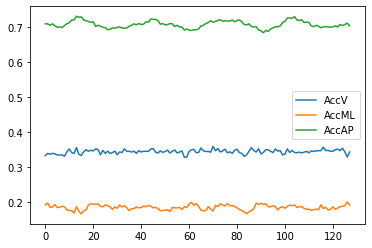

In [25]:
df[['AccV','AccML','AccAP']][0:128].plot()

In [26]:
x_win = []
y_win = []

x = df[['AccV','AccML','AccAP']]
y = df[['fog','normal']]

for i in range(0,len(df)-len(df)%256,128):
    x_win.append(x[i:i+256])
    y_win.append(y[i:i+256])
    
x_win.pop()
y_win.pop()
x_win = np.asarray(x_win,dtype = np.float32)
y_win = np.asarray(y_win,dtype = int)

In [27]:
from scipy import stats
y_win_s2l = []
for i in y_win:
    y_win_s2l.append(stats.mode(i)[0][0])
y_win_s2l = np.asarray(y_win_s2l,dtype = int)

In [28]:
x_win_aug = []
y_win_s2l_aug = []
for i in range(len(y_win_s2l)):
    x_win_aug.append(x_win[i])
    y_win_s2l_aug.append(y_win_s2l[i])
    
    if y_win_s2l[i,0]==1:
        x_win_aug.append(x_win[i])
        y_win_s2l_aug.append(y_win_s2l[i])
x_win_aug = np.asarray(x_win_aug,dtype = np.float32)
y_win_s2l_aug = np.asarray(y_win_s2l_aug,dtype = int)

In [29]:
# Importing Layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization,Input,Bidirectional,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [9]:
# rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="accuracy",factor=0.1,patience=7,)
# earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)
# checkpointer = ModelCheckpoint_tweaked(filepath='best.hdf5', verbose=0, save_best_only=True)
# csv_logger = tf.keras.callbacks.CSVLogger("model_history_log.csv", append=True)

In [10]:
# x_train, x_test, y_train, y_test = train_test_split(x_win_aug, y_win_s2l_aug, test_size=0.10)
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50)

# model_aug = Sequential([
#     LSTM(10, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = True ),
#     Dropout(0.2),
#     LSTM(10, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = False ),
#     Dropout(0.2),
#     Dense(2, activation = 'softmax') 
# ])

# model_aug.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),#, clipvalue=0.5),
#                 loss='categorical_crossentropy', 
#                 metrics=['accuracy'],
                
#                 )

# model_aug.summary()
# tf.config.list_physical_devices('GPU')

In [11]:
# model_aug.fit(x_train, y_train, batch_size = 256, epochs = 1000, callbacks = [rlr,earlystop,checkpointer,csv_logger],validation_data=(x_val,y_val))

In [12]:
# model_aug.evaluate(x_test,y_test)

In [95]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        print(' - lr:',model.optimizer._decayed_lr(tf.float32).numpy())

In [30]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=False)
models = []
evals = []
k = 0
rlr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.001,decay_steps=205,decay_rate=0.96,staircase=True)

In [97]:
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    x_train, x_val, y_train, y_val = train_test_split(x_win_aug[train], y_win_s2l_aug[train], test_size=0.10)

    model = Sequential([
        LSTM(10, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = True ),
        Dropout(0.2),
        LSTM(10, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = False ),
        Dropout(0.2),
        Dense(2, activation = 'softmax') 
    ])
    
    model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = rlr),#, clipvalue=0.5),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'],
                    )

    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=25)
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'best_{k}.hdf5', verbose=0, save_best_only=True,monitor='val_accuracy',mode='max')
    csv_logger = tf.keras.callbacks.CSVLogger(f"history_log_{k}.csv")

    model.fit(x_train, y_train, batch_size = 256, epochs = 500, callbacks = [earlystop,checkpointer,csv_logger,CustomCallback()],validation_data=(x_val,y_val))
    model = tf.keras.models.load_model(f'best_{k}.hdf5')
    models.append(model)
    evals.append(model.evaluate(x_win_aug[test],y_win_s2l_aug[test]))
    
    k+=1

Epoch 1/500
204/204 [==============================] - 14s 52ms/step - loss: 0.6233 - accuracy: 0.6363 - val_loss: 0.5599 - val_accuracy: 0.7018
Epoch 2/500
204/204 [==============================] - 9s 46ms/step - loss: 0.5539 - accuracy: 0.7037 - val_loss: 0.5285 - val_accuracy: 0.7279
Epoch 3/500
204/204 [==============================] - 9s 46ms/step - loss: 0.5781 - accuracy: 0.6851 - val_loss: 0.5701 - val_accuracy: 0.6913
Epoch 4/500
204/204 [==============================] - 9s 46ms/step - loss: 0.5333 - accuracy: 0.7346 - val_loss: 0.5067 - val_accuracy: 0.7615
Epoch 5/500
204/204 [==============================] - 9s 46ms/step - loss: 0.5055 - accuracy: 0.7560 - val_loss: 0.5299 - val_accuracy: 0.7243
Epoch 6/500
204/204 [==============================] - 9s 46ms/step - loss: 0.5021 - accuracy: 0.7555 - val_loss: 0.4908 - val_accuracy: 0.7577
Epoch 7/500
204/204 [==============================] - 9s 46ms/step - loss: 0.4871 - accuracy: 0.7633 - val_loss: 0.4780 - val_accuracy

In [31]:
import tensorflow as tf
models = []
for k in range(5):
    model = tf.keras.models.load_model(f'best_{k}.hdf5')
    models.append(model)

In [32]:
models

In [33]:
import tensorflow_addons as tfa
# x_win_aug[test],y_win_s2l_aug[test]
f1 = []
recalls = []
precisions = []
k = 0
kfold = KFold(n_splits=5, shuffle=False)
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    metric = tfa.metrics.F1Score(num_classes=2,threshold=0.5)

    y_true = y_win_s2l_aug[test]
    y_pred = models[k].predict(x_win_aug[test])

    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    recalls.append(recall.result().numpy())
    
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    precisions.append(precision.result().numpy())
    k+=1
f1 = 2 * (np.array(precisions) * np.array(recalls)) / (np.array(precisions) + np.array(recalls))

452/452 [==============================] - 8s 16ms/step


In [34]:
import pickle
file1 = open('evaluations', 'wb')
file2 = open('models', 'wb')
fil3 = open('scores', 'wb')
pickle.dump(evals, file1)
pickle.dump(models, file2)
pickle.dump([f1,recalls,precisions], file2)
file1.close()
file2.close()

INFO:tensorflow:Assets written to: ram://c25e8231-3bd8-4db1-8f4b-b27a4e5f8b33/assets


INFO:tensorflow:Assets written to: ram://c25e8231-3bd8-4db1-8f4b-b27a4e5f8b33/assets


INFO:tensorflow:Assets written to: ram://284227cb-44ec-49cc-82fa-fdb40ebec8d6/assets


INFO:tensorflow:Assets written to: ram://284227cb-44ec-49cc-82fa-fdb40ebec8d6/assets


INFO:tensorflow:Assets written to: ram://e90559ec-71b5-48a6-9ee6-e17423df3785/assets


INFO:tensorflow:Assets written to: ram://e90559ec-71b5-48a6-9ee6-e17423df3785/assets


INFO:tensorflow:Assets written to: ram://259ef29e-49fc-4c2c-8bda-f3590de78d37/assets


INFO:tensorflow:Assets written to: ram://259ef29e-49fc-4c2c-8bda-f3590de78d37/assets


INFO:tensorflow:Assets written to: ram://fa46e553-0913-4fd2-99e0-11d85c7caa94/assets


INFO:tensorflow:Assets written to: ram://fa46e553-0913-4fd2-99e0-11d85c7caa94/assets


In [116]:
f1

[array([0.84298444, 0.8446248 ], dtype=float32),
 array([0.8025026, 0.8042714], dtype=float32),
 array([0.79161847, 0.7841453 ], dtype=float32),
 array([0.80661637, 0.83907753], dtype=float32),
 array([0.7269514 , 0.77585447], dtype=float32)]

In [117]:
recalls

[0.84395546, 0.8036691, 0.7881368, 0.8245432, 0.7540144]

In [119]:
precisions

[0.8436635, 0.8031131, 0.78775513, 0.8241439, 0.75364923]

array([0.8438095 , 0.803391  , 0.78794587, 0.8243435 , 0.75383174],
      dtype=float32)

In [121]:
sum(recalls)/5

0.8028637766838074

In [122]:
sum(precisions)/5

0.8024649739265441

In [126]:
sum(f1)/5

0.802664315700531